<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/notebooks/2020_0619sketch_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 書画の RNN デモ
- blog: https://magenta.tensorflow.org/sketch_rnn

Python 2.7 required!

<!--In this notebook, we will show how to load pre-trained models and draw things with sketch-rnn-->

In [ ]:
!pip uninstall numpy
!pip install --upgrade numpy==1.16.1

In [ ]:
# Sketch_RNN is required to run on python 2.7!
# import the required libraries
import numpy as np
import time
import random
import cPickle
import codecs
import collections
import os
import math
import json
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from six.moves import xrange

In [ ]:
# libraries required for visualisation:
from IPython.display import SVG, display
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

In [ ]:
#!conda install -c omnia svgwrite=1.1.6
!pip install svgwrite==1.1.6
import svgwrite 

In [ ]:
tf.logging.info("TensorFlow Version: %s", tf.__version__)

I0617 06:44:54.686549 140145516005248 <ipython-input-5-20ed2bf2fd8e>:1] TensorFlow Version: 1.15.0


In [ ]:
!pip install --upgrade magenta

In [ ]:
# import our command line tools
from magenta.models.sketch_rnn.sketch_rnn_train import *
#from magenta.models.sketch_rnn import rnn
from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *

In [ ]:
# little function that displays vector images and saves them to .svg
#def draw_strokes(data, factor=0.2, svg_filename = '/tmp/sketch_rnn/svg/sample.svg'):
def draw_strokes(data, 
                 factor=0.2, 
                 svg_filename='/Users/asakawa/study/2018cnps/jupyter-notebooks/tmp/sketch_rnn/svg/sample.svg'):
  tf.gfile.MakeDirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in xrange(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

# まずは「ヒツジ」を描かせてみる

In [ ]:
data_dir = 'http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/'
models_root_dir = './models'
model_dir = './models/aaron_sheep/layer_norm'

In [ ]:
download_pretrained_models(models_root_dir=models_root_dir)

In [ ]:
def load_env_compatible(data_dir, model_dir):
  """Loads environment for inference mode, used in jupyter notebook."""
  # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
  # to work with depreciated tf.HParams functionality
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    data = json.load(f)
  fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
  for fix in fix_list:
    data[fix] = (data[fix] == 1)
  model_params.parse_json(json.dumps(data))
  return load_dataset(data_dir, model_params, inference_mode=True)

def load_model_compatible(model_dir):
  """Loads model for inference mode, used in jupyter notebook."""
  # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
  # to work with depreciated tf.HParams functionality
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    data = json.load(f)
  fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
  for fix in fix_list:
    data[fix] = (data[fix] == 1)
  model_params.parse_json(json.dumps(data))

  model_params.batch_size = 1  # only sample one at a time
  eval_model_params = sketch_rnn_model.copy_hparams(model_params)
  eval_model_params.use_input_dropout = 0
  eval_model_params.use_recurrent_dropout = 0
  eval_model_params.use_output_dropout = 0
  eval_model_params.is_training = 0
  sample_model_params = sketch_rnn_model.copy_hparams(eval_model_params)
  sample_model_params.max_seq_len = 1  # sample one point at a time
  return [model_params, eval_model_params, sample_model_params]

In [ ]:
[train_set, 
 valid_set, 
 test_set, 
 hps_model, 
 eval_hps_model, 
 sample_hps_model] = load_env_compatible(data_dir, model_dir)

In [ ]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [ ]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

<!--- We define two convenience functions to encode a stroke into a latent vector, and decode from latent vector to stroke.--->

# 動画表象の符号化関数の定義

In [ ]:
def encode(input_strokes):
  strokes = to_big_strokes(input_strokes).tolist()
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  draw_strokes(to_normal_strokes(np.array(strokes)))
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]

# 動画表象の復号化関数の定義

In [ ]:
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor)
  return strokes

# では，実際に描いてみる

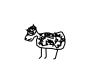

In [ ]:
# get a sample drawing from the test set, and render it to .svg
stroke = test_set.random_sample()
draw_strokes(stroke)

<!--- Let's try to encode the sample stroke into latent vector $z$-->

# 潜在空間上の変数 $z$ を連続的に変化させてみる

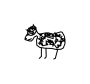

In [ ]:
z = encode(stroke)

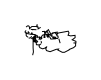

In [ ]:
_ = decode(z, temperature=0.8) # convert z back to drawing at temperature of 0.8

Create generated grid at various temperatures from 0.1 to 1.0

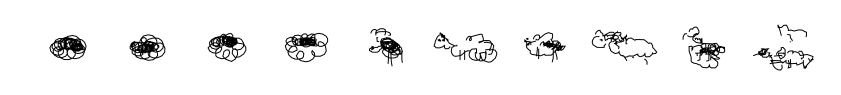

In [ ]:
stroke_list = []
for i in range(10):
  stroke_list.append([decode(z, draw_mode=False, temperature=0.1*i+0.1), [0, i]])
stroke_grid = make_grid_svg(stroke_list)
draw_strokes(stroke_grid)

<!--- Latent Space Interpolation Example between $z_0$ and $z_1$--->

# 潜在変数 $z_0$ から $z_1$ の間の線形内挿

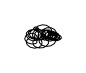

In [ ]:
# get a sample drawing from the test set, and render it to .svg
z0 = z
_ = decode(z0)

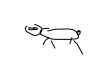

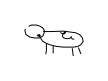

In [ ]:
stroke = test_set.random_sample()
z1 = encode(stroke)
_ = decode(z1)

<!--- Now we interpolate between sheep $z_0$ and sheep $z_1$ --->

# 上の2つの間を内挿してみると

In [ ]:
z_list = [] # interpolate spherically between z0 and z1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z0, z1, t))

In [ ]:
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False), [0, i]])

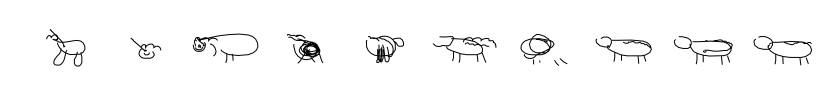

In [ ]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

<!-- Let's load the Flamingo Model, and try Unconditional (Decoder-Only) Generation-->

# 別の画像を使ってみる

In [ ]:
# ユーティリティ関数群を輸入するための Google Drive の認証をする準備
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth

from pydrive.drive import GoogleDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# 認証キーを取得してください。
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Google Drive から zip ファイルを取得します

download = drive.CreateFile({'id': '1hR1lqMTssM6YKVrWJtkeqNwYCjkKL0_p'})
download.GetContentFile('sketch_rnn.zip')

In [ ]:
!unzip sketch_rnn.zip 2&>1 /dev/null 

In [ ]:
model_dir = './models/flamingo/lstm_uncond'
#model_dir = '/Users/asakawa/study/2018tensorflow_magenta-demos.git/jupyter-notebooks/sketch_rnn/models/flamingo/lstm_uncond'

In [ ]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)

In [ ]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

I0617 07:09:00.811131 140145516005248 model.py:89] Model using gpu.
I0617 07:09:00.822161 140145516005248 model.py:177] Input dropout mode = False.
I0617 07:09:00.823683 140145516005248 model.py:178] Output dropout mode = False.
I0617 07:09:00.826052 140145516005248 model.py:179] Recurrent dropout mode = False.
I0617 07:09:02.295129 140145516005248 model.py:89] Model using gpu.
I0617 07:09:02.296902 140145516005248 model.py:177] Input dropout mode = 0.
I0617 07:09:02.298039 140145516005248 model.py:178] Output dropout mode = 0.
I0617 07:09:02.298985 140145516005248 model.py:179] Recurrent dropout mode = 0.
I0617 07:09:02.448373 140145516005248 model.py:89] Model using gpu.
I0617 07:09:02.450198 140145516005248 model.py:177] Input dropout mode = 0.
I0617 07:09:02.452728 140145516005248 model.py:178] Output dropout mode = 0.
I0617 07:09:02.455308 140145516005248 model.py:179] Recurrent dropout mode = 0.


In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [ ]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

I0617 07:09:10.602683 140145516005248 sketch_rnn_train.py:241] Loading model ./models/flamingo/lstm_uncond/vector.
I0617 07:09:10.606842 140145516005248 saver.py:1284] Restoring parameters from ./models/flamingo/lstm_uncond/vector


In [ ]:
# randomly unconditionally generate 10 examples
N = 10
reconstructions = []
for i in range(N):
  #reconstructions.append([decode(temperature=0.5, draw_mode=False), [0, i]])
  reconstructions.append([decode(temperature=0.1, draw_mode=False), [0, i]])

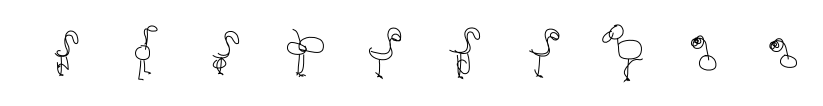

In [ ]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

<!--- Let's load the owl model, and generate two sketches using two random IID gaussian latent vectors-->

# フクロウと別の画像との融合

In [ ]:
model_dir = './models/owl/lstm'

In [ ]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

I0617 07:09:54.582979 140145516005248 model.py:89] Model using gpu.
I0617 07:09:54.597542 140145516005248 model.py:177] Input dropout mode = False.
I0617 07:09:54.599247 140145516005248 model.py:178] Output dropout mode = False.
I0617 07:09:54.600734 140145516005248 model.py:179] Recurrent dropout mode = False.
I0617 07:09:57.171580 140145516005248 model.py:89] Model using gpu.
I0617 07:09:57.173224 140145516005248 model.py:177] Input dropout mode = 0.
I0617 07:09:57.174535 140145516005248 model.py:178] Output dropout mode = 0.
I0617 07:09:57.175779 140145516005248 model.py:179] Recurrent dropout mode = 0.
I0617 07:09:58.099823 140145516005248 model.py:89] Model using gpu.
I0617 07:09:58.102133 140145516005248 model.py:177] Input dropout mode = 0.
I0617 07:09:58.103481 140145516005248 model.py:178] Output dropout mode = 0.
I0617 07:09:58.104536 140145516005248 model.py:179] Recurrent dropout mode = 0.
I0617 07:09:58.869082 140145516005248 sketch_rnn_train.py:241] Loading model ./models

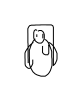

In [ ]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

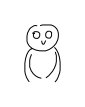

In [ ]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

Let's interpolate between the two owls $z_0$ and $z_1$

In [ ]:
z_list = [] # interpolate spherically between z_0 and z_1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_0, z_1, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.1), [0, i]])

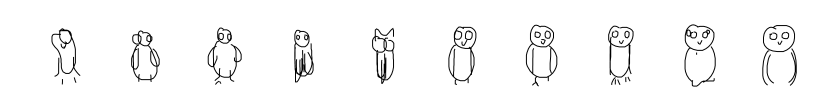

In [ ]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

<!--Let's load the model trained on both cats and buses!  catbus!-->

# ネコとバスの画像の融合 インスパイアードバイ ジブリ lol

In [ ]:
model_dir = './models/catbus/lstm'

In [ ]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

I0617 07:10:47.319298 140145516005248 model.py:89] Model using gpu.
I0617 07:10:47.327560 140145516005248 model.py:177] Input dropout mode = False.
I0617 07:10:47.329366 140145516005248 model.py:178] Output dropout mode = False.
I0617 07:10:47.331978 140145516005248 model.py:179] Recurrent dropout mode = False.
I0617 07:10:50.647830 140145516005248 model.py:89] Model using gpu.
I0617 07:10:50.649856 140145516005248 model.py:177] Input dropout mode = 0.
I0617 07:10:50.651482 140145516005248 model.py:178] Output dropout mode = 0.
I0617 07:10:50.652647 140145516005248 model.py:179] Recurrent dropout mode = 0.
I0617 07:10:51.279994 140145516005248 model.py:89] Model using gpu.
I0617 07:10:51.281869 140145516005248 model.py:177] Input dropout mode = 0.
I0617 07:10:51.283776 140145516005248 model.py:178] Output dropout mode = 0.
I0617 07:10:51.285681 140145516005248 model.py:179] Recurrent dropout mode = 0.
I0617 07:10:52.241648 140145516005248 sketch_rnn_train.py:241] Loading model ./models

# ネコ画像

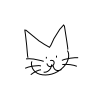

In [ ]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

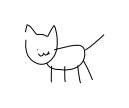

In [ ]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

<!-- Let's interpolate between a cat and a bus!!!-->

# ではやってみよう

In [ ]:
z_list = [] # interpolate spherically between z_1 and z_0
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_1, z_0, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.15), [0, i]])

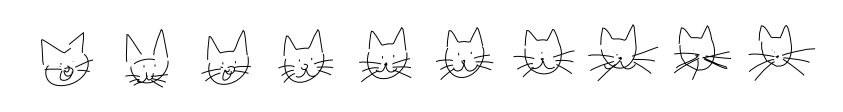

In [ ]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

<!-- Why stop here? Let's load the model trained on both elephants and pigs!!!-->

In [ ]:
model_dir = './models/elephantpig/lstm'

In [ ]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

I0617 07:11:34.646157 140145516005248 model.py:89] Model using gpu.
I0617 07:11:34.657135 140145516005248 model.py:177] Input dropout mode = False.
I0617 07:11:34.658669 140145516005248 model.py:178] Output dropout mode = False.
I0617 07:11:34.661279 140145516005248 model.py:179] Recurrent dropout mode = False.
I0617 07:11:37.327979 140145516005248 model.py:89] Model using gpu.
I0617 07:11:37.331103 140145516005248 model.py:177] Input dropout mode = 0.
I0617 07:11:37.332598 140145516005248 model.py:178] Output dropout mode = 0.
I0617 07:11:37.334311 140145516005248 model.py:179] Recurrent dropout mode = 0.
I0617 07:11:37.738118 140145516005248 model.py:89] Model using gpu.
I0617 07:11:37.739758 140145516005248 model.py:177] Input dropout mode = 0.
I0617 07:11:37.740964 140145516005248 model.py:178] Output dropout mode = 0.
I0617 07:11:37.742014 140145516005248 model.py:179] Recurrent dropout mode = 0.
I0617 07:11:38.996120 140145516005248 sketch_rnn_train.py:241] Loading model ./models

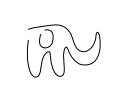

In [ ]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

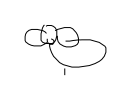

In [ ]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

<!-- Tribute to an episode of [South Park](https://en.wikipedia.org/wiki/An_Elephant_Makes_Love_to_a_Pig): The interpolation between an Elephant and a Pig-->

# 「サウスパーク」の `An_Elephant_Makes_Love_to_a_Pig` を使って...

In [ ]:
z_list = [] # interpolate spherically between z_1 and z_0
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_0, z_1, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  #reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.15), [0, i]])
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.5), [0, i]])